Import needed libraries!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)

from sklearn.metrics import confusion_matrix
import itertools

import keras
import shutil
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
from zipfile import ZipFile

from sklearn.metrics import confusion_matrix
import itertools

Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the base directory and image directory
base_skin_dir = '/content/drive/MyDrive/Skin Lesions Dataset.zip'
base_skin_metadata = '/content/drive/MyDrive/HAM10000_MetaData.csv'

destination_dir = '/content/Skin Lesions'

# Unzip the file
with ZipFile(base_skin_dir, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

#Copy the metadata CSV to the destination folder
shutil.copy(base_skin_metadata, destination_dir)

# List the extracted files
extracted_files = os.listdir(destination_dir)
print("Extracted files:", extracted_files)

base_skin_dir = os.path.join('./Skin Lesions/Skin Lesions Dataset')

Extracted files: ['Skin Lesions Dataset', 'HAM10000_MetaData.csv']


Image pre-processing

In [ ]:
# Merge images from the folder into a dictionary with image IDs as keys and file paths as values
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*.jpg'))}

# This dictionary is useful for displaying more friendly - easier labels

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Read the skin lesions csv

In [ ]:
tile_df = pd.read_csv("./Skin Lesions/HAM10000_MetaData.csv")

tile_df.tail()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,image
5010,1761,HAM_0005274,ISIC_0032766,mel,histo,55.0,male,upper extremity,Melanoma,5,[[[ 0 0 0]\r\n [ 0 0 0]\r\n [ 0 0 0]\r...
5011,2331,HAM_0006617,ISIC_0024669,vasc,histo,25.0,female,abdomen,Vascular lesions,6,[[[161 141 132]\r\n [158 132 109]\r\n [166 1...
5012,500,HAM_0001245,ISIC_0031168,bkl,histo,60.0,male,chest,Benign keratosis-like lesions,2,[[[168 130 141]\r\n [168 128 137]\r\n [168 1...
5013,300,HAM_0004114,ISIC_0026844,bkl,histo,75.0,male,back,Benign keratosis-like lesions,2,[[[140 125 132]\r\n [141 126 133]\r\n [152 1...
5014,2271,HAM_0007530,ISIC_0024410,mel,histo,30.0,male,chest,Melanoma,5,[[[160 138 151]\r\n [170 149 168]\r\n [169 1...


Link text images to the images ids from each row and add an extra column.


In [ ]:
# Create a new column in the DataFrame (path to image) and review the DataFrame


tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get)
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes

tile_df.tail()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,image,path
5010,1761,HAM_0005274,ISIC_0032766,mel,histo,55.0,male,upper extremity,Melanoma,5,[[[ 0 0 0]\r\n [ 0 0 0]\r\n [ 0 0 0]\r...,./Skin Lesions/Skin Lesions Dataset/ISIC_00327...
5011,2331,HAM_0006617,ISIC_0024669,vasc,histo,25.0,female,abdomen,Vascular lesions,6,[[[161 141 132]\r\n [158 132 109]\r\n [166 1...,./Skin Lesions/Skin Lesions Dataset/ISIC_00246...
5012,500,HAM_0001245,ISIC_0031168,bkl,histo,60.0,male,chest,Benign keratosis-like lesions,2,[[[168 130 141]\r\n [168 128 137]\r\n [168 1...,./Skin Lesions/Skin Lesions Dataset/ISIC_00311...
5013,300,HAM_0004114,ISIC_0026844,bkl,histo,75.0,male,back,Benign keratosis-like lesions,2,[[[140 125 132]\r\n [141 126 133]\r\n [152 1...,./Skin Lesions/Skin Lesions Dataset/ISIC_00268...
5014,2271,HAM_0007530,ISIC_0024410,mel,histo,30.0,male,chest,Melanoma,5,[[[160 138 151]\r\n [170 149 168]\r\n [169 1...,./Skin Lesions/Skin Lesions Dataset/ISIC_00244...


Add Benign && Non-Benign tags to each

In [ ]:
# Create a list of benign lesion types
benign_types = ['Actinic keratoses', 'Benign keratosis-like lesions', 'Melanocytic nevi', 'Dermatofibroma']

# Create 'benign_status' column
tile_df['benign_status'] = tile_df['cell_type'].apply(lambda x: 'Benign' if x not in benign_types else 'Non-Benign')

# Display the updated DataFrame
tile_df.tail()


,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,image,path,benign_status
5010,1761,HAM_0005274,ISIC_0032766,mel,histo,55.0,male,upper extremity,Melanoma,5,[[[ 0 0 0]\r\n [ 0 0 0]\r\n [ 0 0 0]\r...,./Skin Lesions/Skin Lesions Dataset/ISIC_00327...,Benign
5011,2331,HAM_0006617,ISIC_0024669,vasc,histo,25.0,female,abdomen,Vascular lesions,6,[[[161 141 132]\r\n [158 132 109]\r\n [166 1...,./Skin Lesions/Skin Lesions Dataset/ISIC_00246...,Benign
5012,500,HAM_0001245,ISIC_0031168,bkl,histo,60.0,male,chest,Benign keratosis-like lesions,2,[[[168 130 141]\r\n [168 128 137]\r\n [168 1...,./Skin Lesions/Skin Lesions Dataset/ISIC_00311...,Benign
5013,300,HAM_0004114,ISIC_0026844,bkl,histo,75.0,male,back,Benign keratosis-like lesions,2,[[[140 125 132]\r\n [141 126 133]\r\n [152 1...,./Skin Lesions/Skin Lesions Dataset/ISIC_00268...,Benign
5014,2271,HAM_0007530,ISIC_0024410,mel,histo,30.0,male,chest,Melanoma,5,[[[160 138 151]\r\n [170 149 168]\r\n [169 1...,./Skin Lesions/Skin Lesions Dataset/ISIC_00244...,Benign


In [ ]:
# Print the total number of rows and columns
print("Total rows and columns before removing 'None' values:", tile_df.shape)

# Remove rows with 'None' in the 'path' column
tile_df = tile_df[tile_df['path'].notna()]

# Print the total number of rows and columns after removing 'None' values
print("Total rows and columns after removing 'None' values:", tile_df.shape)


Total rows and columns before removing 'None' values: (5015, 13)
Total rows and columns after removing 'None' values: (5015, 13)


The distribution of different cell types

<Axes: >

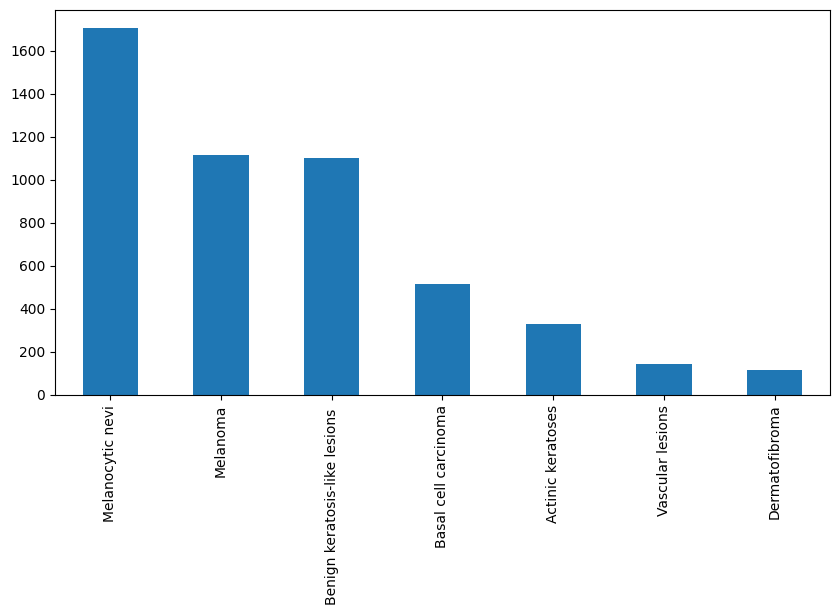

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

Too many melanocytic nevi - let's balance it a bit!

<Axes: >

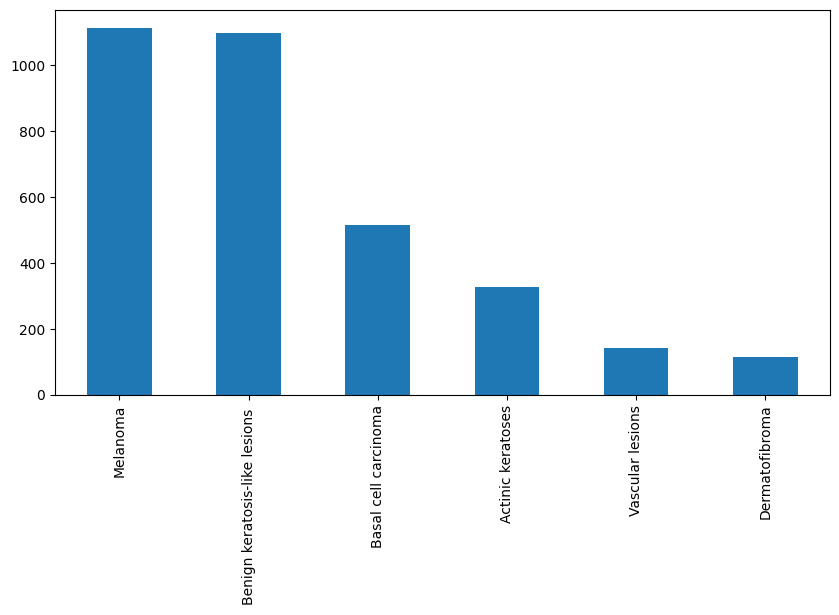

In [ ]:
tile_df = tile_df.drop(tile_df[tile_df.cell_type_idx == 4].iloc[:5000].index)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
input_dims = (32, 32)
input_shape = input_dims + (3,)

# Load in all of the images into memory - this will take a while.
# I also do a resize step because the original dimensions of 450 * 600 * 3 was too much for TensorFlow

tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))

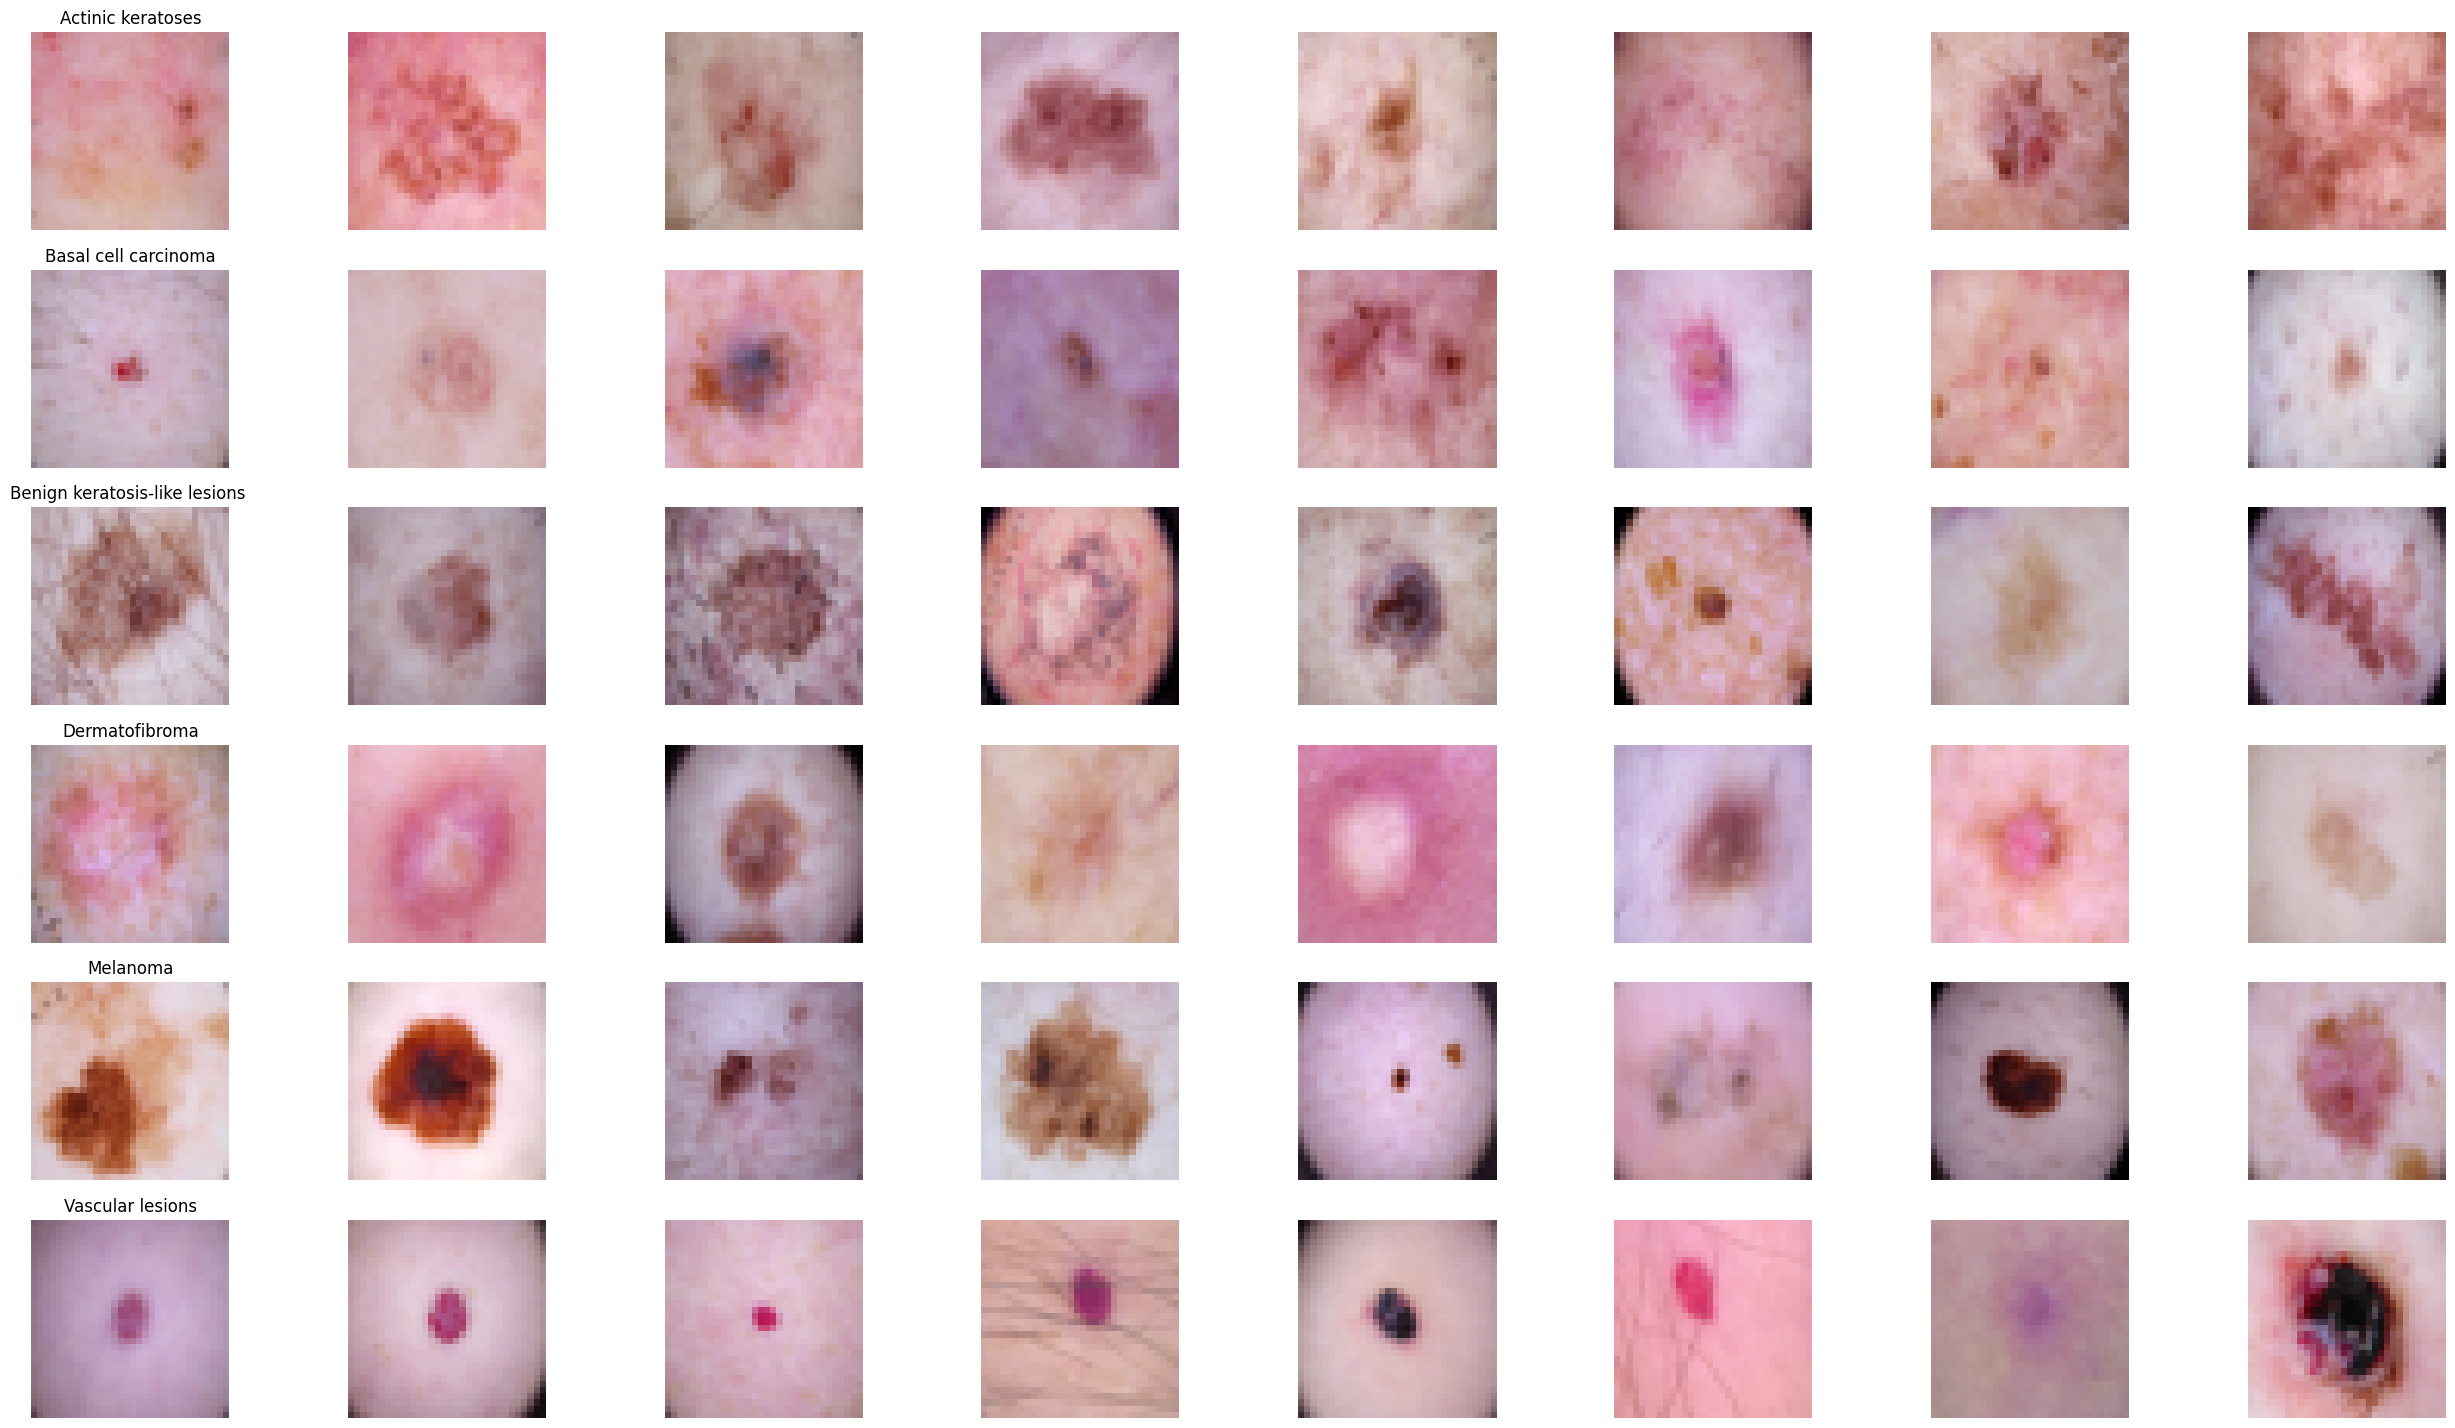

In [ ]:
# Find the unique types of skin lesions
unique_types = tile_df['cell_type'].unique()

# Get the number of unique types
num_unique_types = len(unique_types)

# Define the number of columns (samples per row)
n_samples = 8

# Create the subplot grid with the appropriate number of rows and columns
fig, m_axs = plt.subplots(num_unique_types, n_samples, figsize=(4 * n_samples, 3 * num_unique_types))

# Loop through the unique types and plot samples for each type
for n_axs, (type_name, type_rows) in zip(m_axs, tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Remove any empty subplots if there are fewer unique types than the number of rows
if num_unique_types < len(m_axs):
    for ax in m_axs.flat[num_unique_types * n_samples:]:
        ax.axis('off')

# Save the figure
fig.savefig('category_samples.png', dpi=300)

Export to csv

In [ ]:
tile_df.to_csv('processed_data.csv')

y = tile_df.cell_type_idx
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(tile_df, y, test_size=0.25)

Training the model

In [ ]:

# Preprocessing
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

y_train = to_categorical(y_train_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)

# Model configuration
input_shape = (32, 32, 3)
num_classes = 7

# Define the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
initial_learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 128)       147584    
                                                      

Fitting the model

In [ ]:
# Train the model with data augmentation
epochs = 50
batch_size = 128

history = model.fit(data_augmentation.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))

Epoch 1/50
19/19 [==============================] - 16s 103ms/step - loss: 4.6978 - accuracy: 0.3828 - val_loss: 3.1695 - val_accuracy: 0.4517
Epoch 2/50
19/19 [==============================] - 2s 119ms/step - loss: 2.4614 - accuracy: 0.4333 - val_loss: 1.9771 - val_accuracy: 0.4444
Epoch 3/50
19/19 [==============================] - 1s 77ms/step - loss: 1.7624 - accuracy: 0.4380 - val_loss: 1.6000 - val_accuracy: 0.4783
Epoch 4/50
19/19 [==============================] - 2s 79ms/step - loss: 1.4997 - accuracy: 0.4732 - val_loss: 1.4984 - val_accuracy: 0.4601
Epoch 5/50
19/19 [==============================] - 2s 81ms/step - loss: 1.4132 - accuracy: 0.4732 - val_loss: 1.3388 - val_accuracy: 0.5121
Epoch 6/50
19/19 [==============================] - 2s 79ms/step - loss: 1.3356 - accuracy: 0.4890 - val_loss: 1.2459 - val_accuracy: 0.5386
Epoch 7/50
19/19 [==============================] - 2s 79ms/step - loss: 1.2591 - accuracy: 0.5225 - val_loss: 1.2184 - val_accuracy: 0.5531
Epoch 8/50

Graphs for accuracy and loss during training and validation

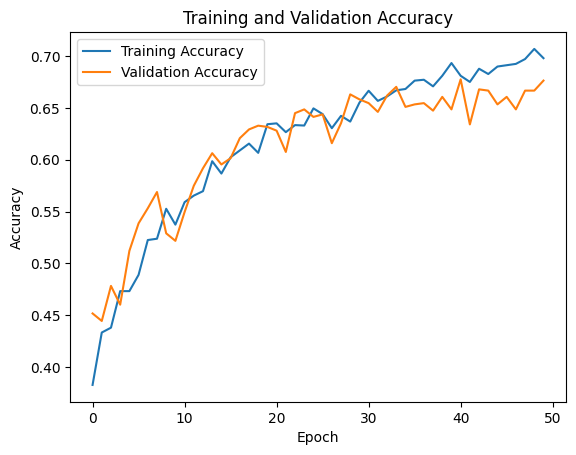

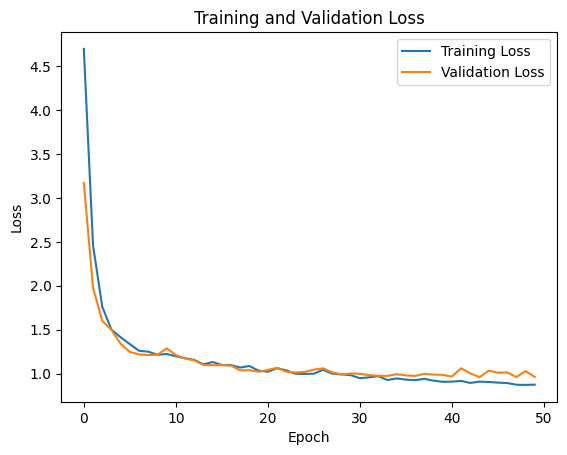

In [ ]:
# Train and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Train and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate the model on the test dataset and plot the accuracy and loss for the test dataset

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plot the accuracy and loss for the test dataset
predictions = model.predict(x_test)
test_labels = np.argmax(y_test, axis=1)
test_predictions = np.argmax(predictions, axis=1)

# Test accuracy
correct = np.sum(test_labels == test_predictions)
total = len(test_labels)
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

# Test loss
test_loss = keras.losses.categorical_crossentropy(y_test, predictions).numpy().mean()
print(f'Test Loss: {test_loss:.4f}')

# Mapping class indices to lesion type names
lesion_type_dict = {
    0: 'Melanocytic nevi',
    1: 'Melanoma',
    2: 'Benign keratosis-like lesions',
    3: 'Basal cell carcinoma',
    4: 'Actinic keratoses',
    5: 'Vascular lesions',
    6: 'Dermatofibroma'
}

# Display the predictions and ground truth for a few examples
num_examples = 10
for i in range(num_examples):
    predicted_label = lesion_type_dict[test_predictions[i]]
    correct_label = lesion_type_dict[test_labels[i]]
    print(f"Example {i + 1}: Predicted: {predicted_label}, Correct: {correct_label}")


Test Loss: 6.8369, Test Accuracy: 0.0531
26/26 [==============================] - 0s 2ms/step
Test Accuracy: 0.0531
Test Loss: 2.0950
Example 1: Predicted: Basal cell carcinoma, Correct: Vascular lesions
Example 2: Predicted: Melanocytic nevi, Correct: Melanocytic nevi
Example 3: Predicted: Melanocytic nevi, Correct: Benign keratosis-like lesions
Example 4: Predicted: Basal cell carcinoma, Correct: Basal cell carcinoma
Example 5: Predicted: Basal cell carcinoma, Correct: Melanoma
Example 6: Predicted: Basal cell carcinoma, Correct: Basal cell carcinoma
Example 7: Predicted: Melanocytic nevi, Correct: Benign keratosis-like lesions
Example 8: Predicted: Melanocytic nevi, Correct: Vascular lesions
Example 9: Predicted: Melanocytic nevi, Correct: Vascular lesions
Example 10: Predicted: Basal cell carcinoma, Correct: Benign keratosis-like lesions


Save the model in SavedModel format


In [ ]:
# The SavedModel will be saved in a directory named 'skin_lesion_model'
model.save('skin_lesion_model')

# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('skin_lesion_model')
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a specific directory in Colab runtime
output_path = '/content/skin_lesion_model.tflite'
with open(output_path, 'wb') as f:
    f.write(tflite_model)


Model for Benign and Non-Benign skin lesions

In [ ]:
# Preprocessing
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

# Create binary labels for benign (1) and non-benign (0)
y_train_binary = np.where(y_train_o.isin(benign_types), 1, 0)
y_test_binary = np.where(y_test_o.isin(benign_types), 1, 0)

# Model configuration
input_shape = (32, 32, 3)
num_classes_binary = 1  # Binary classification

# Define the binary classification model
model_binary = Sequential()
model_binary.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_binary.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_binary.add(MaxPooling2D(pool_size=(2, 2)))
model_binary.add(Dropout(0.25))

model_binary.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_binary.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_binary.add(MaxPooling2D(pool_size=(2, 2)))
model_binary.add(Dropout(0.25))

model_binary.add(Flatten())
model_binary.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_binary.add(Dropout(0.5))
model_binary.add(Dense(num_classes_binary, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the binary model
initial_learning_rate_binary = 0.001
opt_binary = keras.optimizers.Adam(learning_rate=initial_learning_rate_binary)
model_binary.compile(loss='binary_crossentropy',
                     optimizer=opt_binary,
                     metrics=['accuracy'])

# Print the binary model summary
model_binary.summary()

# Data augmentation (use the same data augmentation settings as the previous model)
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 128)       147584    
                                                      

Fitting the model

In [ ]:
# Compile the binary model
initial_learning_rate_binary = 0.001
opt_binary = keras.optimizers.Adam(learning_rate=initial_learning_rate_binary)
model_binary.compile(loss='binary_crossentropy',
                     optimizer=opt_binary,
                     metrics=['accuracy'])

# Print the binary model summary
model_binary.summary()

# Data augmentation (use the same data augmentation settings as the previous model)
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)

# Fit the binary model
batch_size = 32
epochs = 10

history_binary = model_binary.fit(
    data_augmentation.flow(x_train, y_train_binary, batch_size=batch_size),
    steps_per_epoch=len(x_train) / batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test_binary),
    verbose=1
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 10, 10, 128)       147584    
                                                      

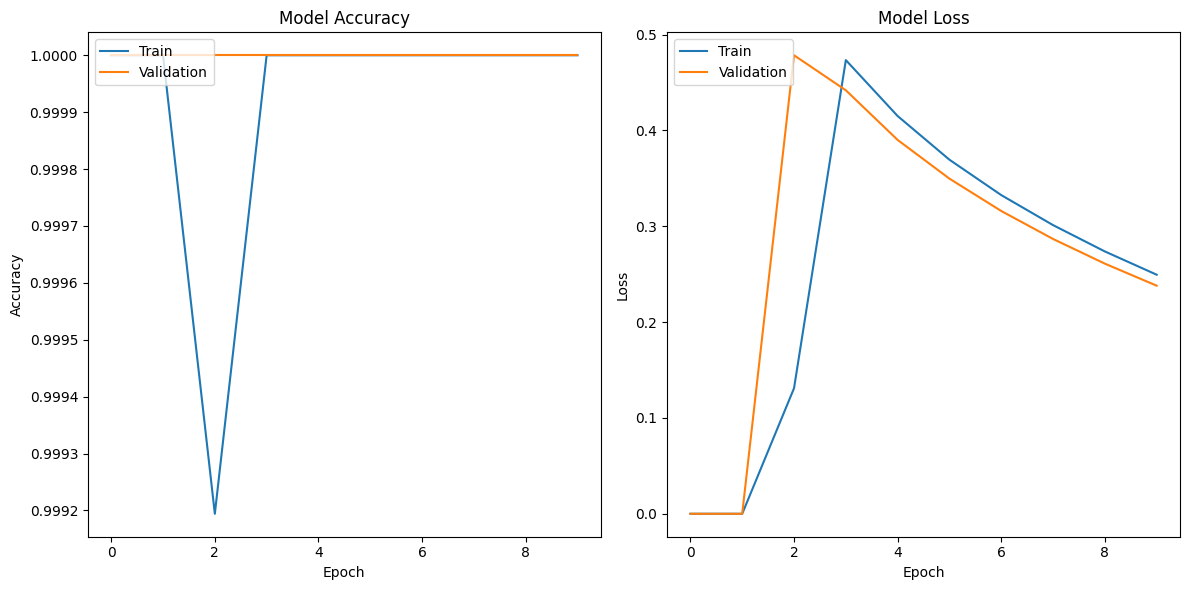

Benign        2868
Non-Benign     442
Name: benign_status, dtype: int64


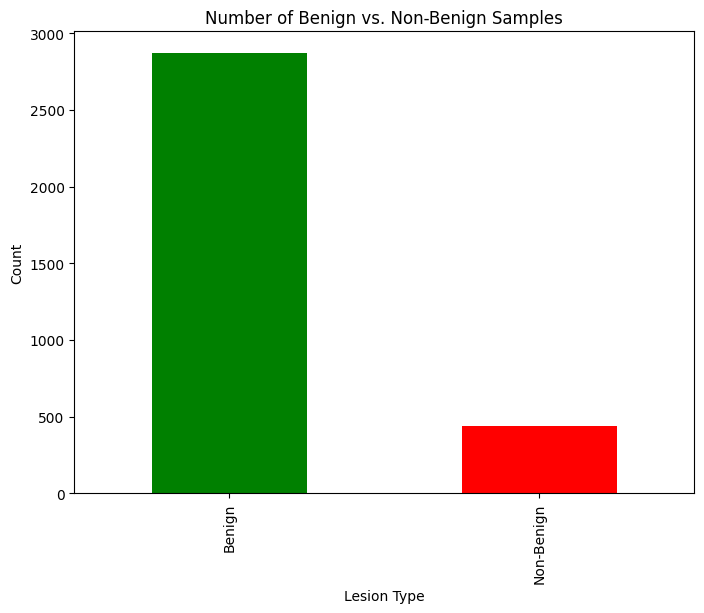

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history_binary)



# Count the number of samples for each class in the dataset
class_counts = tile_df['benign_status'].value_counts()

# Display the counts
print(class_counts)

# Plot the counts
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Number of Benign vs. Non-Benign Samples')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.show()



#Using ResNet50 alone

In [ ]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

input_dims_resnet = (32, 32)
input_shape_resnet = input_dims_resnet + (3,)

# Load pre-trained ResNet50 model without the top classification layer
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape_resnet)

# Freeze the pre-trained layers
for layer in base_model_resnet.layers:
    layer.trainable = False

# Create a new model
model_resnet = Sequential()
model_resnet.add(base_model_resnet)
model_resnet.add(GlobalAveragePooling2D())
model_resnet.add(Dense(7, activation='softmax'))

# Compile the ResNet50-based model
model_resnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the ResNet50-based model summary
model_resnet.summary()

# Data augmentation for ResNet50
data_augmentation_resnet = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)

# Train the ResNet50-based model
epochs_resnet = 50
batch_size_resnet = 64

history_resnet = model_resnet.fit(
    data_augmentation_resnet.flow(x_train, y_train, batch_size=batch_size_resnet),
    steps_per_epoch=len(x_train) // batch_size_resnet,
    epochs=epochs_resnet,
    validation_data=(x_test, y_test),
    verbose=1
)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_6  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 7)                 14343     
                                                                 
Total params: 23602055 (90.03 MB)
Trainable params: 14343 (56.03 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1/50
38/38 [==============================] - 15s 154ms/step - loss: 1.5285 - accuracy: 0.4012 - val_loss: 1.4563 - val_accuracy: 0.3937
Epoch 2/50
38/38 [==============================] - 2s 55ms/step

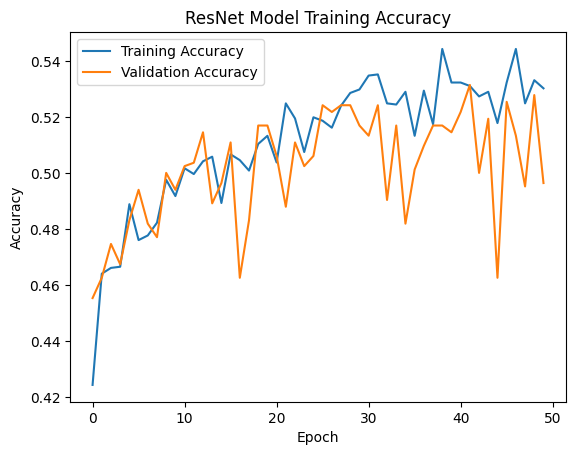

In [ ]:
import matplotlib.pyplot as plt

# Plot the training accuracy
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Using ResNet50 + Custom Layers.

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_26 (Dense)            (None, 256)               524544    
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 24114055 (91.99 MB)
Trainable params: 526343 (2.01 MB)
Non-trainable params: 23587712 (89.98 MB)
________

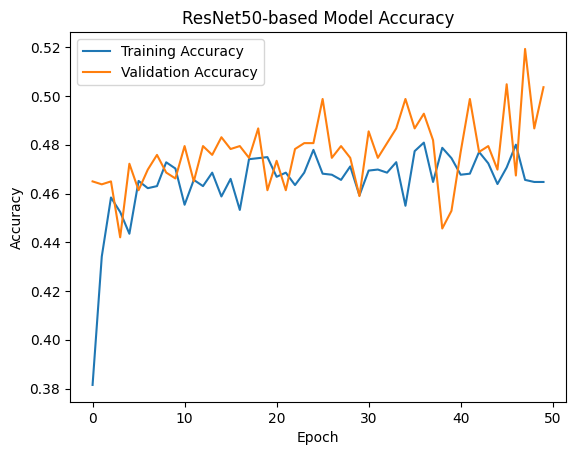

In [ ]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.preprocessing import image
from keras import regularizers
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

input_dims = (32, 32)
input_shape = input_dims + (3,)

# Load in all of the images into memory
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))

# Preprocessing
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(tile_df, tile_df.cell_type_idx, test_size=0.25)

# Convert images to numpy arrays
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

# Normalize pixel values
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

# One-hot encode the labels
y_train = to_categorical(y_train_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)

# Load pre-trained ResNet50 model without the top classification layer
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model_resnet.layers:
    layer.trainable = False

# Create a multi-class classification model on top of ResNet50
model_resnet = Sequential()
model_resnet.add(base_model_resnet)
model_resnet.add(GlobalAveragePooling2D())
model_resnet.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_resnet.add(Dropout(0.5))
model_resnet.add(Dense(7, activation='softmax'))

# Compile the ResNet50-based model
initial_learning_rate_resnet = 0.001
opt_resnet = keras.optimizers.Adam(learning_rate=initial_learning_rate_resnet)
model_resnet.compile(loss='categorical_crossentropy',
                     optimizer=opt_resnet,
                     metrics=['accuracy'])

# Print the ResNet50-based model summary
model_resnet.summary()

# Data augmentation
data_augmentation_resnet = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)

# Fit the ResNet50-based model
history_resnet = model_resnet.fit(
    data_augmentation_resnet.flow(x_train, y_train, batch_size=batch_size_resnet),
    steps_per_epoch=len(x_train) // batch_size_resnet,
    epochs=epochs_resnet,
    validation_data=(x_test, y_test),
    verbose=1
)

# Plot accuracy
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50-based Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Using VGG16 alone

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_7  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_11 (Dense)            (None, 7)                 3591      
                                                                 
Total params: 14718279 (56.15 MB)
Trainable params: 3591 (14.03 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/50
38/38 [==============================] - 8s 140ms/step - loss: 1.5757 - accuracy: 0.3449 - val_loss: 1.4277 - val_accuracy: 0.3973
Epoch 2/50
38/38 [==============================] - 2s 64ms/step -

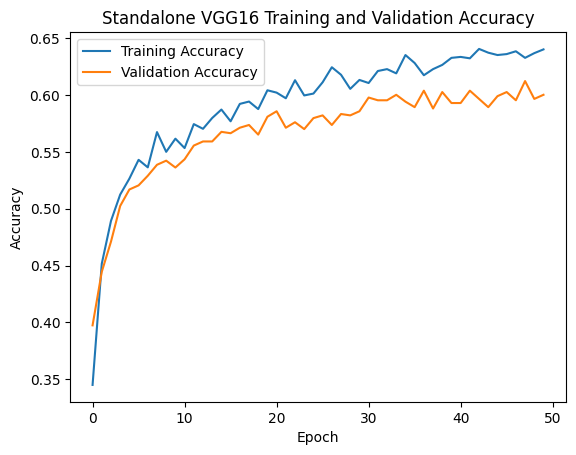

In [ ]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

input_dims = (32, 32)
input_shape = input_dims + (3,)

# Standalone VGG16
model_vgg16_standalone = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in model_vgg16_standalone.layers:
    layer.trainable = False

# Create a new model
model_standalone = Sequential()

# Add the VGG16 base model
model_standalone.add(model_vgg16_standalone)

# Add Global Average Pooling layer
model_standalone.add(GlobalAveragePooling2D())

# Add Dense layer for classification
model_standalone.add(Dense(7, activation='softmax'))  # 7 prediction classes

# Compile the model
model_standalone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_standalone.summary()

# Data augmentation for VGG16
data_augmentation_vgg16 = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)

# Train the standalone VGG16 model
epochs_standalone = 50
batch_size_standalone = 64

history_standalone = model_standalone.fit(
    data_augmentation_vgg16.flow(x_train, y_train, batch_size=batch_size_standalone),
    steps_per_epoch=len(x_train) // batch_size_standalone,
    epochs=epochs_standalone,
    validation_data=(x_test, y_test),
    verbose=1
)

# Plot accuracy
plt.plot(history_standalone.history['accuracy'], label='Training Accuracy')
plt.plot(history_standalone.history['val_accuracy'], label='Validation Accuracy')
plt.title('Standalone VGG16 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Using VGG16 + Custom Layers

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d_8  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 14847815 (56.64 MB)
Trainable params: 133127 (520.03 KB)
Non-trainable params: 14714688 (56.13 MB)
______

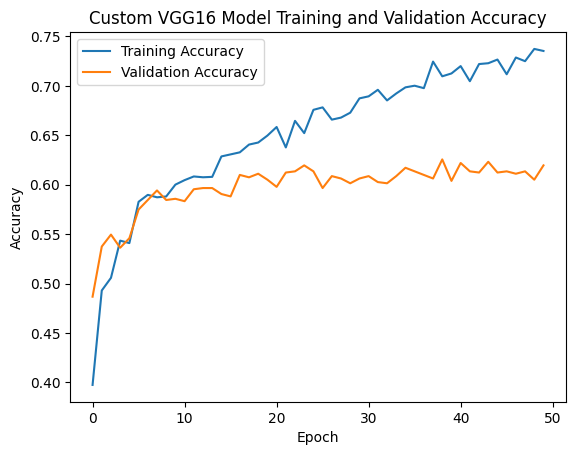

In [ ]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

input_dims = (32, 32)
input_shape = input_dims + (3,)

# Standalone VGG16
model_vgg16_standalone = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in model_vgg16_standalone.layers:
    layer.trainable = False

# Create a new model
model_custom_vgg16 = Sequential()

# Add the VGG16 base model
model_custom_vgg16.add(model_vgg16_standalone)

# Add Global Average Pooling layer
model_custom_vgg16.add(GlobalAveragePooling2D())

# Additional Dense layers
model_custom_vgg16.add(Dense(256, activation='relu'))
model_custom_vgg16.add(Dropout(0.5))

# Output layer
model_custom_vgg16.add(Dense(7, activation='softmax'))  # 7 classes

# Compile the model
model_custom_vgg16.compile(optimizer=Adam(learning_rate=0.001),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Print the model summary
model_custom_vgg16.summary()

# Data augmentation for custom VGG16
data_augmentation_custom_vgg16 = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)

# Train the custom VGG16 model
epochs_custom_vgg16 = 50
batch_size_custom_vgg16 = 64

history_custom_vgg16 = model_custom_vgg16.fit(
    data_augmentation_custom_vgg16.flow(x_train, y_train, batch_size=batch_size_custom_vgg16),
    steps_per_epoch=len(x_train) // batch_size_custom_vgg16,
    epochs=epochs_custom_vgg16,
    validation_data=(x_test, y_test),
    verbose=1
)

# Plot accuracy
plt.plot(history_custom_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_custom_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('Custom VGG16 Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# BASIC MODEL / ResNet50 / VGG16 Comparison

26/26 [==============================] - 0s 10ms/step - loss: 6.6933 - accuracy: 0.0556
Basic Model Test Accuracy: 0.0555555559694767
26/26 [==============================] - 1s 25ms/step - loss: 1.2312 - accuracy: 0.5471
ResNet50 Model Test Accuracy: 0.5471014380455017
26/26 [==============================] - 0s 11ms/step - loss: 1.0742 - accuracy: 0.6002
VGG16 Model Test Accuracy: 0.6002415418624878
26/26 [==============================] - 0s 7ms/step
Confusion Matrix for Basic Model:


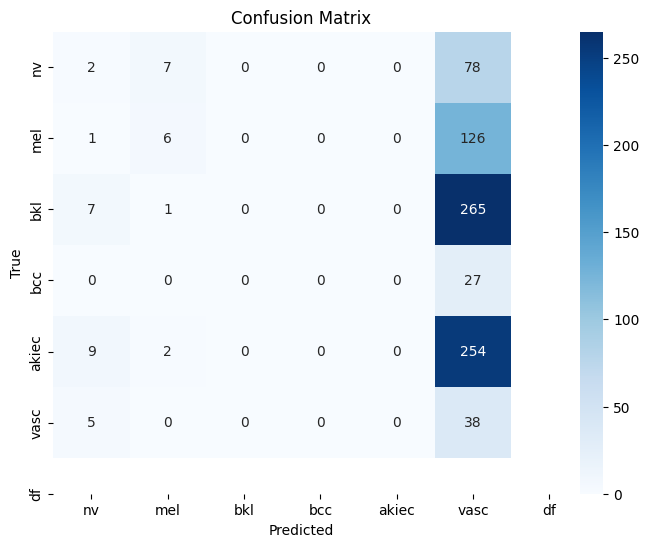


Confusion Matrix for ResNet50 Model:


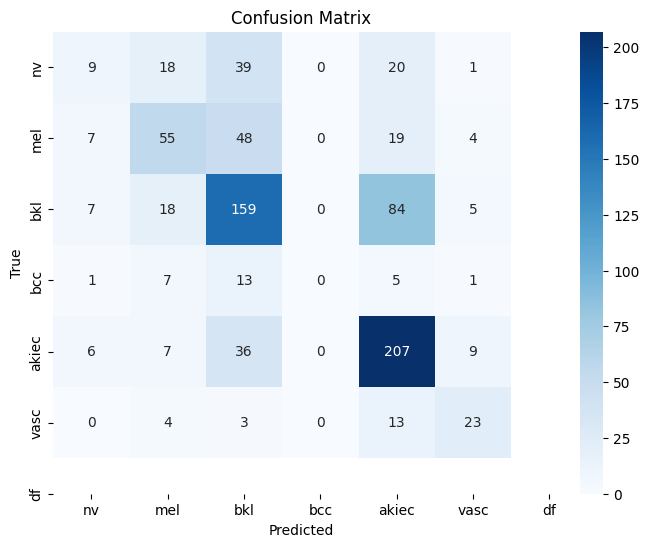


Confusion Matrix for VGG16 Model:


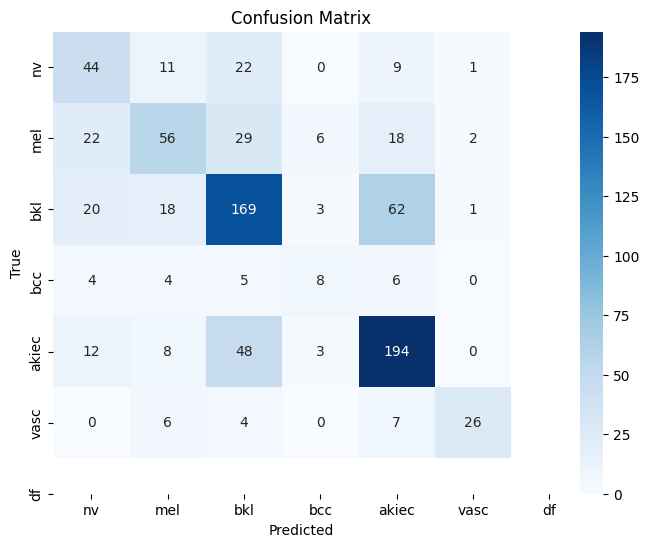

In [ ]:
# Evaluate the basic model
accuracy_basic = model.evaluate(x_test, y_test)[1]
print(f'Basic Model Test Accuracy: {accuracy_basic}')

# Evaluate the ResNet50-based model
accuracy_resnet = model_resnet.evaluate(x_test, y_test)[1]
print(f'ResNet50 Model Test Accuracy: {accuracy_resnet}')

# Evaluate the VGG16-based model
accuracy_vgg16 = model_standalone.evaluate(x_test, y_test)[1]
print(f'VGG16 Model Test Accuracy: {accuracy_vgg16}')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Get predictions for each model
y_pred_basic = np.argmax(model.predict(x_test), axis=1)
y_pred_resnet = np.argmax(model_resnet.predict(x_test), axis=1)
y_pred_vgg16 = np.argmax(model_standalone.predict(x_test), axis=1)

# Replace class names with skin lesion labels
class_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

# Convert one-hot encoded labels back to single column
y_true_single_column = np.argmax(y_test, axis=1)

# Print model names
print("Confusion Matrix for Basic Model:")
# Plot confusion matrix for the basic model
plot_confusion_matrix(y_true_single_column, y_pred_basic, class_names)

print("\nConfusion Matrix for ResNet50 Model:")
# Plot confusion matrix for the ResNet50 model
plot_confusion_matrix(y_true_single_column, y_pred_resnet, class_names)

print("\nConfusion Matrix for VGG16 Model:")
# Plot confusion matrix for the VGG16 model
plot_confusion_matrix(y_true_single_column, y_pred_vgg16, class_names)





In [ ]:
# Colab2PDF v1.0.4 by Drengskapur (github.com/drengskapur/colab2pdf) (License: GPL-3.0-or-later)
# @title {display-mode:"form"}
# @markdown ⬇️ Download PDF
def colab2pdf():
    ENABLE=True # @param {type:"boolean"}
    if ENABLE:
        !apt-get install librsvg2-bin
        import os, datetime, json, locale, pathlib, urllib, requests, werkzeug, nbformat, google, yaml, warnings
        locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
        NAME = pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f"http://{os.environ['COLAB_JUPYTER_IP']}:{os.environ['KMP_TARGET_PORT']}/api/sessions").json()[0]["name"])))
        TEMP = pathlib.Path("/content/pdfs") / f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{NAME.stem}"; TEMP.mkdir(parents=True, exist_ok=True)
        NB = [cell for cell in nbformat.reads(json.dumps(google.colab._message.blocking_request("get_ipynb", timeout_sec=600)["ipynb"]), as_version=4).cells if "--Colab2PDF" not in cell.source]
        warnings.filterwarnings('ignore', category=nbformat.validator.MissingIDFieldWarning)
        with (TEMP / f"{NAME.stem}.ipynb").open("w", encoding="utf-8") as nb_copy: nbformat.write(nbformat.v4.new_notebook(cells=NB or [nbformat.v4.new_code_cell("#")]), nb_copy)
        if not pathlib.Path("/usr/local/bin/quarto").exists():
            !wget -q "https://quarto.org/download/latest/quarto-linux-amd64.deb" -P {TEMP} && dpkg -i {TEMP}/quarto-linux-amd64.deb > /dev/null && quarto install tinytex --update-path --quiet
        with (TEMP / "config.yml").open("w", encoding="utf-8") as file: yaml.dump({'include-in-header': [{"text": r"\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}"}],'include-before-body': [{"text": r"\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}"}]}, file)
        !quarto render {TEMP}/{NAME.stem}.ipynb --metadata-file={TEMP}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
        google.colab.files.download(str(TEMP / f"{NAME.stem}.pdf"))
colab2pdf()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  librsvg2-bin
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 1,871 kB of archives.
After this operation, 6,019 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 librsvg2-bin amd64 2.52.5+dfsg-3ubuntu0.2 [1,871 kB]
Fetched 1,871 kB in 1s (1,403 kB/s)
Selecting previously unselected package librsvg2-bin.
(Reading database ... 121666 files and directories currently installed.)
Preparing to unpack .../librsvg2-bin_2.52.5+dfsg-3ubuntu0.2_amd64.deb ...
Unpacking librsvg2-bin (2.52.5+dfsg-3ubuntu0.2) ...
Setting up librsvg2-bin (2.52.5+dfsg-3ubuntu0.2) ...
Processing triggers for man-db (2.10.2-1) ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>